In [18]:
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, CRD, DCD2, PDB_small
from MDAnalysis.analysis import distances,diffusionmap, align, rms,contacts,dihedrals, encore
from MDAnalysis.analysis.rms import RMSF
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from mpl_toolkits.axisartist.parasite_axes import SubplotHost
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
from itertools import product
import timeit
import time
import math
import os.path
import seaborn as sns
import pandas as pd
import csv
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
import scipy.signal as sig
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import scipy.integrate as integrate
import scipy.special as special

In [4]:
path='/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/'
u_wta=mda.Universe(path+'wt_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'wt_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_wtb=mda.Universe(path+'wt_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'wt_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_dma=mda.Universe(path+'dm_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'dm_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_dmb=mda.Universe(path+'dm_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'dm_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_delP168a=mda.Universe(path+'delP168_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'delP168_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_delP168b=mda.Universe(path+'delP168_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'delP168_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_a173va=mda.Universe(path+'a173v_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'a173v_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_a173vb=mda.Universe(path+'a173v_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'a173v_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

In [28]:
def calc_m49_q189_hbond(u,title):
    
    def unit_vector(vector):
        return(vector/np.linalg.norm(vector))
    def angle_between(v1,v2):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return(math.degrees(np.arccos(np.clip(np.dot(v1_u,v2_u),-1.0,1.0))))
    
    dist=[]
    angle=[]
    hbond=[]
    m49o=u.select_atoms("resid 49 and name O")
    q189n=u.select_atoms("resid 189 and name N")
    q189h=u.select_atoms("resid 189 and name HN")
    for ts in u.trajectory:
        m49o_coor=u.select_atoms("resid 49 and name O").center_of_geometry()
        q189n_coor=u.select_atoms("resid 189 and name N").center_of_geometry()
        q189h_coor=u.select_atoms("resid 189 and name HN").center_of_geometry()
        dist1=np.min(distances.distance_array(m49o_coor,q189n_coor))
        dist.append((dist1))
        vec1=m49o_coor-q189h_coor
        vec2=q189n_coor-q189h_coor
        angle1=angle_between(vec1,vec2)
        angle.append(angle1)
        if dist1 < 4 and 120 < angle1 < 200:
            hbond.append(1)
        else:
            hbond.append(0)
    
    results=[]
    for i,j,k in zip(dist,angle,hbond):
        results.append((i,j,k))
    
    results=np.array(results).reshape(len(dist),3)
    
    with open('{}_q189_m49_hbond.npy'.format(title),'wb') as f:
        np.save(f,results)   
    
    print("Finished")
    
    return(results)

In [29]:
wta_hbond=calc_m49_q189_hbond(u_wta,"wt_chainA")
wtb_hbond=calc_m49_q189_hbond(u_wtb,"wt_chainb")

Finished
Finished


In [30]:
dma_hbond=calc_m49_q189_hbond(u_dma,"dm_chainA")
dmb_hbond=calc_m49_q189_hbond(u_dmb,"dm_chainb")

Finished
Finished


In [31]:
delP168a_hbond=calc_m49_q189_hbond(u_delP168a,"delP168_chainA")
delP168b_hbond=calc_m49_q189_hbond(u_delP168b,"delP168_chainb")

Finished
Finished


In [32]:
a173va_hbond=calc_m49_q189_hbond(u_a173va,"a173v_chainA")
a173vb_hbond=calc_m49_q189_hbond(u_a173vb,"a173v_chainb")

Finished
Finished


660000


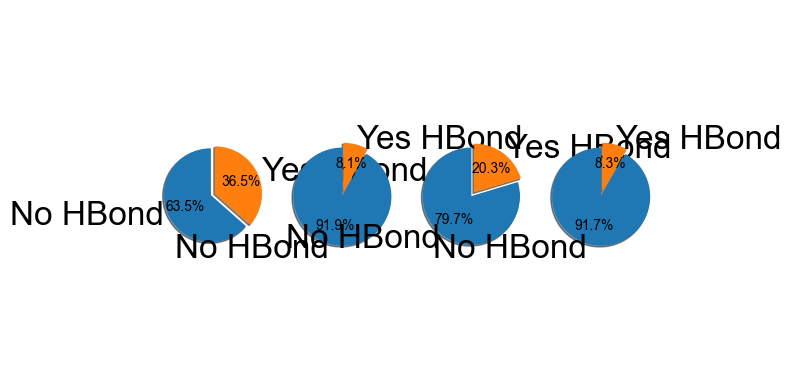

In [41]:
wt_all_hbond=wta_hbond[:,2].tolist()+wtb_hbond[:,2].tolist()
dm_all_hbond=dma_hbond[:,2].tolist()+dmb_hbond[:,2].tolist()
delP168_all_hbond=delP168a_hbond[:,2].tolist()+delP168b_hbond[:,2].tolist()
a173v_all_hbond=a173va_hbond[:,2].tolist()+a173vb_hbond[:,2].tolist()


print(len(wt_all_hbond))
def count_hbonds(dat):
    counts=[0,0]
    for i in dat:
        if i == 0:
            counts[0]=counts[0]+1
        else:
            counts[1]=counts[1]+1
    return(counts)

labels=["No HBond","Yes HBond"]
wt_sizes=count_hbonds(wt_all_hbond)
dm_sizes=count_hbonds(dm_all_hbond)
delP168_sizes=count_hbonds(delP168_all_hbond)
a173v_sizes=count_hbonds(a173v_all_hbond)
explode=[0,0.1]

fig1, ax = plt.subplots(1,4)
ax[0].pie(wt_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].pie(dm_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].pie(delP168_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[3].pie(a173v_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[3].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

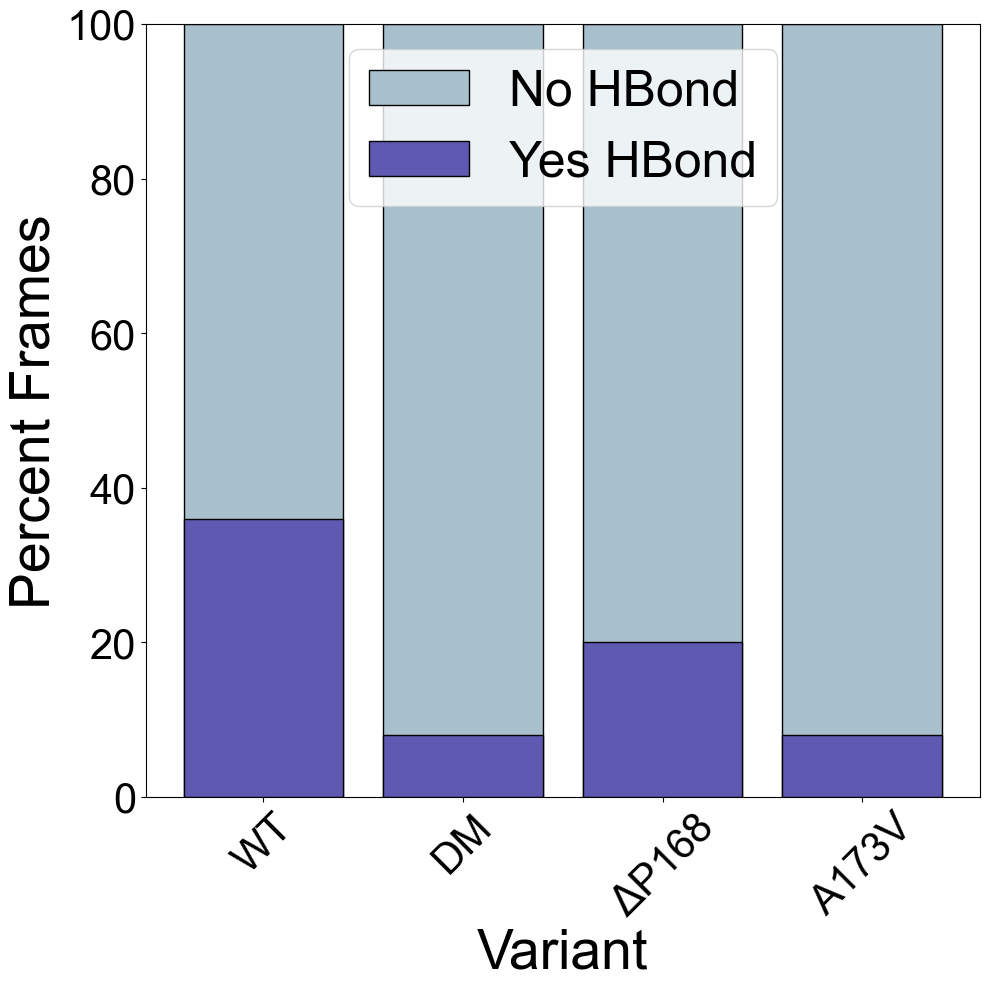

In [58]:
params = {
         'font.family': 'sans-serif',
         'font.sans-serif': 'Arial',
         'legend.fontsize': '36',
         #'figure.figsize': (24,12),
         'axes.labelsize': '40',
         'axes.titlesize': '40',
         'xtick.labelsize': '30',
         'ytick.labelsize': '30'
         #'xtick.size': '30'
         #'ytick.size': '30'
}
    
pylab.rcParams.update(params)


def calc_percent_hbonds(dat):
    counts=[0,0]
    for i in dat:
        if i == 0:
            counts[0]=counts[0]+1
        else:
            counts[1]=counts[1]+1
    percents=[math.floor(counts[0]*100/len(dat)),math.floor(counts[1]*100/len(dat))]
    return(percents)

labels=["No HBond","Yes HBond"]
wt_percent_hbonds=calc_percent_hbonds(wt_all_hbond)
dm_percent_hbonds=calc_percent_hbonds(dm_all_hbond)
delP168_percent_hbonds=calc_percent_hbonds(delP168_all_hbond)
a173v_percent_hbonds=calc_percent_hbonds(a173v_all_hbond)


x=range(4)
xlabels=["WT","DM","$\Delta$P168","A173V"]
percent_no_hbonds=[100]*4
percent_yes_hbonds=[wt_percent_hbonds[1],dm_percent_hbonds[1],delP168_percent_hbonds[1],a173v_percent_hbonds[1]]
colors=sns.color_palette('twilight_shifted',4)
fig=plt.figure(figsize=(10,10))
plt.bar(x,percent_no_hbonds,color=colors[1],edgecolor='k',label="No HBond")
plt.bar(x,percent_yes_hbonds,color=colors[0],edgecolor='k',label="Yes HBond")
plt.xlabel("Variant")
plt.xticks(x,xlabels,rotation=45)
plt.ylabel("Percent Frames")
plt.ylim([0,100])
plt.legend()
fig.tight_layout()
plt.savefig('{}_percentage_hbond.png'.format("wt_dm_delP168_a173v"),dpi=300)

(array([1.06997e+05, 7.07700e+04, 6.95310e+04, 4.16140e+04, 2.34490e+04,
        1.30550e+04, 3.91900e+03, 5.98000e+02, 5.50000e+01, 1.20000e+01]),
 array([ 2.51035427,  3.82498558,  5.1396169 ,  6.45424821,  7.76887952,
         9.08351084, 10.39814215, 11.71277346, 13.02740477, 14.34203609,
        15.6566674 ]),
 <BarContainer object of 10 artists>)

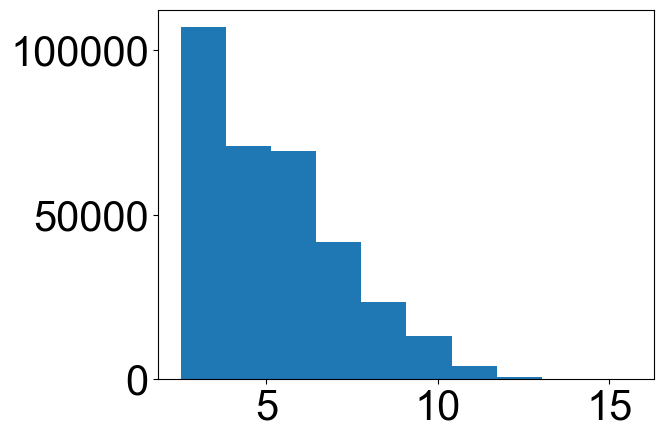

In [47]:
plt.hist(wta_hbond[:,0])

In [12]:
wt_all=np.concatenate((wta_hbond,wtb_hbond))
dm_all=np.concatenate((dma_hbond,dmb_hbond))
delP168_all=np.concatenate((delP168a_hbond,delP168b_hbond))
a173v_all=np.concatenate((a173va_hbond,a173vb_hbond))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


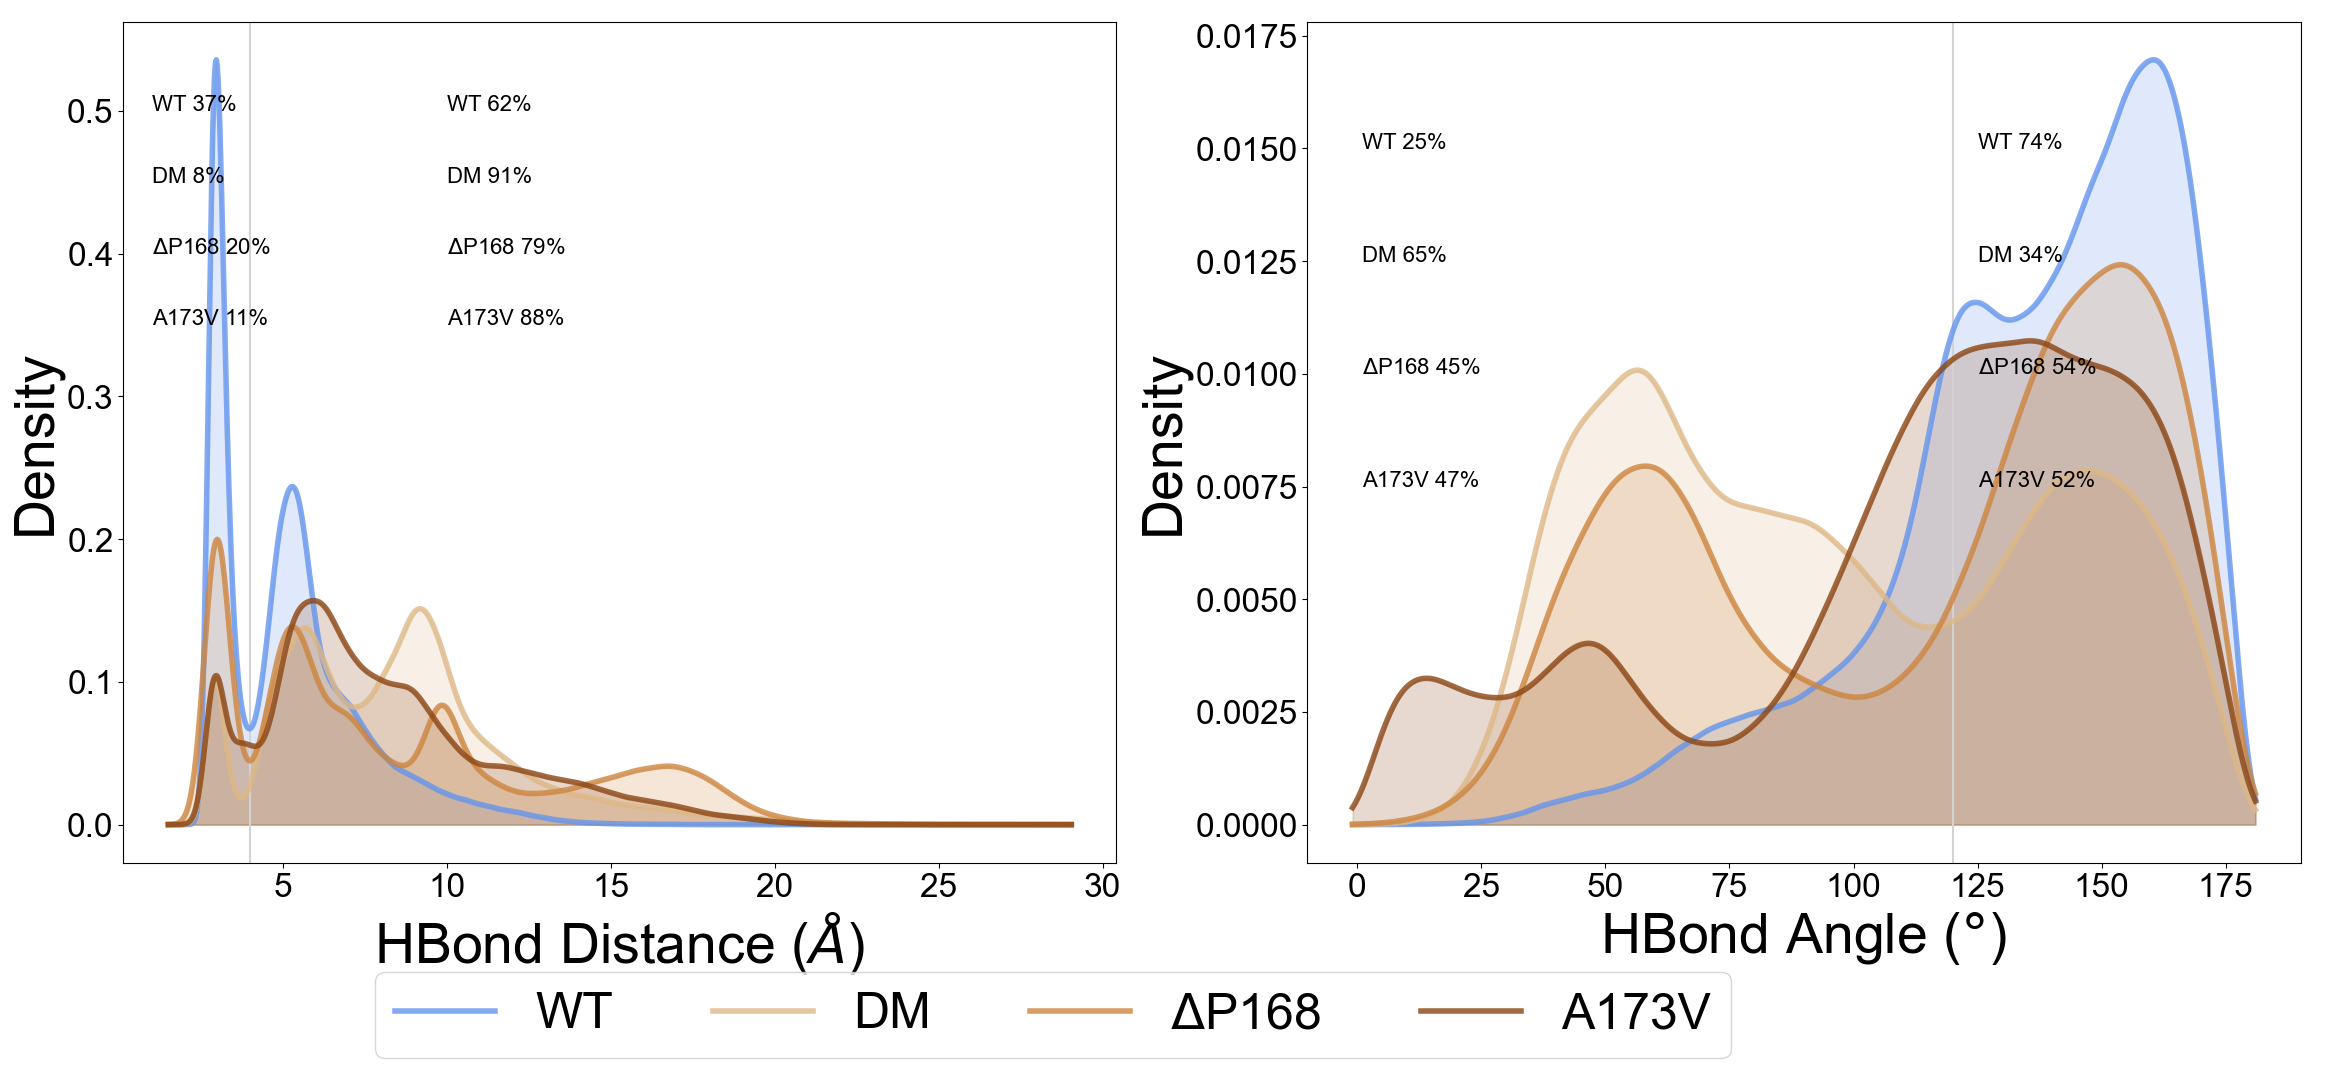

In [23]:
plot_distributions(wt_all,dm_all,delP168_all,a173v_all,"wt_dm_delP168_a173v_all")

In [22]:
def plot_distributions(wt,dm,delP168,a173v,title):
    params = {
         'font.family': 'sans-serif',
         'font.sans-serif': 'Arial',
         'legend.fontsize': '36',
         #'figure.figsize': (24,12),
         'axes.labelsize': '40',
         'axes.titlesize': '40',
         'xtick.labelsize': '24',
         'ytick.labelsize': '24'
         #'xtick.size': '30'
         #'ytick.size': '30'
    }
    
    pylab.rcParams.update(params)
        
    def calc_dist_auc(function):
        auc0_percent=math.floor(integrate.quad(function,0,4)[0]*100)
        auc1_percent=math.floor(integrate.quad(function,4,30)[0]*100)
        return(auc0_percent,auc1_percent)    
    
    def calc_angle_auc(function):
        auc0_percent=math.floor(integrate.quad(function,0,120)[0]*100)
        auc1_percent=math.floor(integrate.quad(function,120,180)[0]*100)
        return(auc0_percent,auc1_percent)
    
    dist_collection=wt[:,0].tolist()+dm[:,0].tolist()+delP168[:,0].tolist()+a173v[:,0].tolist()
    dist_start=np.min(dist_collection)-1
    dist_stop=np.max(dist_collection)+1
    angle_collection=wt[:,1].tolist()+dm[:,1].tolist()+delP168[:,1].tolist()+a173v[:,1].tolist()
    angle_start=np.min(angle_collection)-1
    angle_stop=np.max(angle_collection)+1
    
    domain_dist = np.linspace(dist_start,dist_stop,1000)
    dens_wt_dist = gaussian_kde(wt[:,0].tolist())
    dens_wt_dist.covariance_factor = lambda : 0.25
    dens_dm_dist = gaussian_kde(dm[:,0].tolist())
    dens_dm_dist.covariance_factor = lambda : 0.25
    dens_delP168_dist = gaussian_kde(delP168[:,0].tolist())
    dens_delP168_dist.covariance_factor = lambda : 0.25
    dens_a173v_dist = gaussian_kde(a173v[:,0].tolist())
    dens_a173v_dist.covariance_factor = lambda : 0.25
    
    domain_angle = np.linspace(angle_start,angle_stop,1000)
    dens_wt_angle = gaussian_kde(wt[:,1].tolist())
    dens_wt_angle.covariance_factor = lambda : 0.25
    dens_dm_angle = gaussian_kde(dm[:,1].tolist())
    dens_dm_angle.covariance_factor = lambda : 0.25
    dens_delP168_angle = gaussian_kde(delP168[:,1].tolist())
    dens_delP168_angle.covariance_factor = lambda : 0.25
    dens_a173v_angle = gaussian_kde(a173v[:,1].tolist())
    dens_a173v_angle.covariance_factor = lambda : 0.25
    
    wt_dist_auc0,wt_dist_auc1=calc_dist_auc(dens_wt_dist)
    dm_dist_auc0,dm_dist_auc1=calc_dist_auc(dens_dm_dist)
    delP168_dist_auc0,delP168_dist_auc1=calc_dist_auc(dens_delP168_dist)
    a173v_dist_auc0,a173v_dist_auc1=calc_dist_auc(dens_a173v_dist)
    
    wt_angle_auc0,wt_angle_auc1=calc_angle_auc(dens_wt_angle)
    dm_angle_auc0,dm_angle_auc1=calc_angle_auc(dens_dm_angle)
    delP168_angle_auc0,delP168_angle_auc1=calc_angle_auc(dens_delP168_angle)
    a173v_angle_auc0,a173v_angle_auc1=calc_angle_auc(dens_a173v_angle)
    
    #fig = plt.figure(figsize=(12,8))
    fig, axs = plt.subplots(1,2, sharex=False, sharey=False, tight_layout=True, figsize=(24,12))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    ## plot a_XXX's together
    axs[0].axvline(x=4,color='lightgrey',linestyle='-')
    axs[1].axvline(x=120,color='lightgrey',linestyle='-')
    p1, = axs[0].plot(domain_dist,dens_wt_dist(domain_dist),color='cornflowerblue',alpha=0.8,linewidth=4,label='WT') ## column 2 = interface 1
    axs[0].fill_between(domain_dist,dens_wt_dist(domain_dist),color='cornflowerblue',alpha=0.2)
    p2, = axs[0].plot(domain_dist,dens_dm_dist(domain_dist),color='burlywood',alpha=0.8,linewidth=4,label='DM') ## column 2 = interface 1
    axs[0].fill_between(domain_dist,dens_dm_dist(domain_dist),color='burlywood',alpha=0.2)
    p3, = axs[0].plot(domain_dist,dens_delP168_dist(domain_dist),color='peru',alpha=0.8,linewidth=4,label="$\Delta$P168") ## column 2 = interface 1
    axs[0].fill_between(domain_dist,dens_delP168_dist(domain_dist),color='peru',alpha=0.2)
    p4, = axs[0].plot(domain_dist,dens_a173v_dist(domain_dist),color='saddlebrown',alpha=0.8,linewidth=4,label='A173V') ## column 2 = interface 1
    axs[0].fill_between(domain_dist,dens_a173v_dist(domain_dist),color='saddlebrown',alpha=0.2)
    axs[0].set_xlabel("HBond Distance ($\AA{}$)")
    axs[0].set_ylabel("Density")

    
    axs[1].plot(domain_angle,dens_wt_angle(domain_angle),color='cornflowerblue',alpha=0.8,linewidth=4,label='WT') ## column 2 = interface 1
    axs[1].fill_between(domain_angle,dens_wt_angle(domain_angle),color='cornflowerblue',alpha=0.2)
    axs[1].plot(domain_angle,dens_dm_angle(domain_angle),color='burlywood',alpha=0.8,linewidth=4,label='DM') ## column 2 = interface 1
    axs[1].fill_between(domain_angle,dens_dm_angle(domain_angle),color='burlywood',alpha=0.2)
    axs[1].plot(domain_angle,dens_delP168_angle(domain_angle),color='peru',alpha=0.8,linewidth=4,label="$\Delta$P168") ## column 2 = interface 1
    axs[1].fill_between(domain_angle,dens_delP168_angle(domain_angle),color='peru',alpha=0.2)
    axs[1].plot(domain_angle,dens_a173v_angle(domain_angle),color='saddlebrown',alpha=0.8,linewidth=4,label='A173V') ## column 2 = interface 1
    axs[1].fill_between(domain_angle,dens_a173v_angle(domain_angle),color='saddlebrown',alpha=0.2)
    axs[1].set_xlabel("HBond Angle ($\degree$)")
    axs[1].set_ylabel("Density")

    axs[0].annotate("WT {}%".format(wt_dist_auc0),(1,0.5),xycoords='data',fontsize=16)
    axs[0].annotate("DM {}%".format(dm_dist_auc0),(1,0.45),xycoords='data',fontsize=16)
    axs[0].annotate("$\Delta$P168 {}%".format(delP168_dist_auc0),(1,0.4),xycoords='data',fontsize=16)
    axs[0].annotate("A173V {}%".format(a173v_dist_auc0),(1,0.35),xycoords='data',fontsize=16)
    axs[0].annotate("WT {}%".format(wt_dist_auc1),(10,0.5),xycoords='data',fontsize=16)
    axs[0].annotate("DM {}%".format(dm_dist_auc1),(10,0.45),xycoords='data',fontsize=16)
    axs[0].annotate("$\Delta$P168 {}%".format(delP168_dist_auc1),(10,0.4),xycoords='data',fontsize=16)
    axs[0].annotate("A173V {}%".format(a173v_dist_auc1),(10,0.35),xycoords='data',fontsize=16)
    
    axs[1].annotate("WT {}%".format(wt_angle_auc0),(1,0.015),xycoords='data',fontsize=16)
    axs[1].annotate("DM {}%".format(dm_angle_auc0),(1,0.0125),xycoords='data',fontsize=16)
    axs[1].annotate("$\Delta$P168 {}%".format(delP168_angle_auc0),(1,0.01),xycoords='data',fontsize=16)
    axs[1].annotate("A173V {}%".format(a173v_angle_auc0),(1,0.0075),xycoords='data',fontsize=16)
    axs[1].annotate("WT {}%".format(wt_angle_auc1),(125,0.015),xycoords='data',fontsize=16)
    axs[1].annotate("DM {}%".format(dm_angle_auc1),(125,0.0125),xycoords='data',fontsize=16)
    axs[1].annotate("$\Delta$P168 {}%".format(delP168_angle_auc1),(125,0.010),xycoords='data',fontsize=16)
    axs[1].annotate("A173V {}%".format(a173v_angle_auc1),(125,0.0075),xycoords='data',fontsize=16)
    
    #plt.title("Distribution of C145-S to H41-N Dist")
    #plt.ylabel("Density",labelpad=40)
    #plt.xlabel("C145-S to H41-N Dist ($\AA{}$)")
    
    
    plt.legend(fontsize=36)
    plt.legend(handles=[p1, p2, p3, p4],bbox_to_anchor=(0.75,-0.1),ncol=4,fontsize=36)
    fig.tight_layout()
    plt.savefig('{}_m49_q189_hbond.png'.format(title),bbox_inches='tight',dpi=300)